In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from unidecode import unidecode
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
import locale
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
import shap
import pickle
from joblib import parallel_backend

locale.setlocale(locale.LC_ALL, 'es_CL')

plt.style.use("seaborn")

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [2]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_5_dummy_ohe.csv.gz")
df.head()

,dur_estudio_carr,dur_proceso_tit,desertor_1,prom_notas_media,fscu,gratuidad,beca,dif_ing_ult_mat,edad,valor_arancel,...,decil_50,decil_60,decil_70,decil_80,decil_90,decil_100,sub_tipo_inst_cft_estatal,sub_tipo_inst_cft_privado,sub_tipo_inst_ip_privado,sub_tipo_inst_ip_privado_precencia_nacional
0,5,1,1,5.5,0,0,1,0,31,1850000.0,...,0,0,0,0,0,0,0,0,0,1
1,6,1,0,4.7,0,0,0,0,29,803000.0,...,0,1,0,0,0,0,0,1,0,0
2,5,1,0,6.4,0,0,0,0,16,1480000.0,...,0,0,1,0,0,0,0,0,0,1
3,8,0,1,5.9,0,0,0,0,17,1700900.0,...,0,0,0,0,0,0,0,0,0,1
4,7,1,0,5.7,0,0,0,0,18,1600000.0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
df.shape

(731675, 73)

In [4]:
df["desertor_1"].value_counts("%"), df["desertor_1"].value_counts()

(0    0.786662
 1    0.213338
 Name: desertor_1, dtype: float64,
 0    575581
 1    156094
 Name: desertor_1, dtype: int64)

# Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["desertor_1"]), df["desertor_1"], random_state=42, test_size=0.10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((658507, 72), (73168, 72), (658507,), (73168,))

In [6]:
pd.Series(y_train).value_counts("%") * 100

0    78.648215
1    21.351785
Name: desertor_1, dtype: float64

In [23]:
pd.Series(y_test).value_counts()

0    57677
1    15491
Name: desertor_1, dtype: int64

# Undersampling

In [7]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled.shape

(281206, 72)

In [8]:
pd.Series(y_resampled).value_counts() 

0    140603
1    140603
Name: desertor_1, dtype: int64

In [9]:
frecuencias = pd.concat([
    X_train.loc[:, "misma_region": "dependencia_colegio_particular_subvencionado"].sum() / X_train.shape[0] * 100,
    X_resampled.loc[:, "misma_region": "dependencia_colegio_particular_subvencionado"].sum() / X_resampled.shape[0] * 100,
], axis=1)
frecuencias[np.abs(frecuencias[0] - frecuencias[1]) > 0.5]

,0,1
gen_alu_hombre,49.249287,52.285513
gen_alu_mujer,50.750713,47.714487
tipo_inst_1_centros_de_formacion_tecnica,33.260391,34.916040
tipo_inst_1_institutos_profesionales,66.739609,65.083960
jornada_diurno,60.708238,57.183702
jornada_vespertino,37.435745,40.873950
area_conocimiento_administracion_y_comercio,25.743234,25.207144
area_conocimiento_salud,15.022012,14.181419
area_conocimiento_tecnologia,34.411479,35.972561
acreditada_carr_acreditada,58.686544,58.168033


## XGBoost

In [9]:
def plot_importance(fit_model, feat_names, n=10):
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1][:n]
    names = [feat_names[i] for i in sort_importance]
    plt.title("Feature importance")
    plt.barh(range(n), list(reversed(tmp_importance[sort_importance])))
    plt.yticks(range(n), list(reversed(names)), rotation=0)
    return names

In [11]:
clf_pipe = Pipeline(
    steps=[
        ("selection", SelectPercentile(f_classif)),
        ("clf", XGBClassifier(random_state=42))
    ]
)

clf_pipe

Pipeline(steps=[('selection', SelectPercentile()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [12]:
param_grid = {
    "selection__percentile": [80, 95],
    "clf__n_estimators": [200, 500],
    "clf__subsample": [0.5, 1],
    "clf__lambda": [0.5, 1, 2]
}

In [13]:
search = GridSearchCV(
    clf_pipe, param_grid, n_jobs=-1, scoring="f1_macro", cv=5, verbose=10
)

In [11]:
search = pickle.load(open("search_xgb_decil.p", "rb"))

In [12]:
search.best_params_

{'clf__lambda': 0.5,
 'clf__n_estimators': 500,
 'clf__subsample': 1,
 'selection__percentile': 95}

In [13]:
x_features = search.best_estimator_[0].fit_transform(X_resampled, y_resampled)
columns = np.asarray(X_resampled.columns.values)
support = np.asarray(search.best_estimator_[0].get_support())
columns_with_support = columns[support]
columns_with_support

array(['dur_estudio_carr', 'dur_proceso_tit', 'prom_notas_media', 'fscu',
       'gratuidad', 'beca', 'dif_ing_ult_mat', 'edad', 'valor_arancel',
       'misma_region', 'gen_alu_hombre', 'gen_alu_mujer',
       'tipo_inst_1_centros_de_formacion_tecnica',
       'tipo_inst_1_institutos_profesionales', 'jornada_a_distancia',
       'jornada_diurno', 'jornada_otro', 'jornada_semipresencial',
       'jornada_vespertino', 'region_sede_antofagasta',
       'region_sede_arica_y_parinacota', 'region_sede_atacama',
       'region_sede_aysen', 'region_sede_biobio', 'region_sede_coquimbo',
       'region_sede_la_araucania', 'region_sede_lib_gral_b_ohiggins',
       'region_sede_los_lagos', 'region_sede_los_rios',
       'region_sede_magallanes', 'region_sede_metropolitana',
       'region_sede_valparaiso',
       'area_conocimiento_administracion_y_comercio',
       'area_conocimiento_agropecuaria',
       'area_conocimiento_arte_y_arquitectura',
       'area_conocimiento_ciencias_basicas',
     

In [14]:
print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.67      0.77     57677
           1       0.38      0.74      0.50     15491

    accuracy                           0.69     73168
   macro avg       0.64      0.70      0.63     73168
weighted avg       0.79      0.69      0.71     73168



In [15]:
print(classification_report(search.predict(X_resampled), y_resampled))

              precision    recall  f1-score   support

           0       0.73      0.78      0.76    132685
           1       0.79      0.75      0.77    148521

    accuracy                           0.76    281206
   macro avg       0.76      0.76      0.76    281206
weighted avg       0.76      0.76      0.76    281206



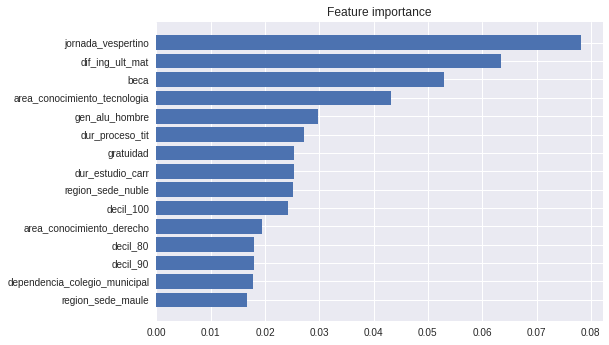

In [16]:
_ = plot_importance(search.best_estimator_[1], df.drop(columns=["desertor_1"]).columns, n=15)

In [17]:
def class_feature_importance(X, Y, feature_importances, n_feats=10):
    sort_importance = np.argsort(feature_importances)[::-1]#[:n_feats]
    feat_names = X.columns
    names = [feat_names[i] for i in sort_importance]
    importancias = feature_importances[sort_importance]
    N, M = X[names].shape
    X = scale(X[names])

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(N), np.mean(X[Y==c, :], axis=0)*importancias)
        )

    #return out, names
    t = pd.DataFrame(out)
    t["atributo"] = names
    t["abs"] = t[0].abs()
    return t.sort_values(by=["abs"], ascending=False).head(n_feats).sort_values(by=["abs"])

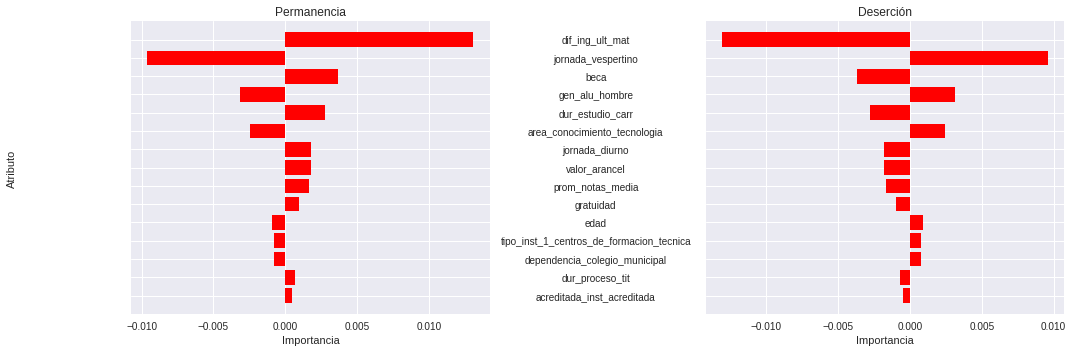

In [18]:
result = class_feature_importance(
    X_resampled, y_resampled, search.best_estimator_[1].feature_importances_, 15
)

titles = ["Permanencia", "Deserción"]
plt.figure(figsize=(15, 5))
for t, i in zip(titles, range(len(set(y_resampled)))):
    ax = plt.subplot(1, 2, i+1)
    plt.title(t)
    plt.barh(
        range(len(result[i])),
        result[i],
        color="r",
        align="center"
    )
    plt.yticks(
        range(len(result[i])),
        result["atributo"] if i == 1 else [""] * result.shape[0],
        rotation=0,
        ha="center"
    )
    plt.xlabel("Importancia")
    if i == 0:
        plt.ylabel("Atributo")
    ax.tick_params(axis='y', which='major', pad=110)
    plt.ylim([-1, len(result[i])])
    
plt.tight_layout()

In [19]:
result["atributo"] = result["atributo"].replace(
    ["dif_ing_ult_mat"], ["años_cursados"]
)

result["atributo"] = [
    a.replace("_", " ").title()
    for a in result["atributo"]
]

Text(0, 0.5, 'Atributo')

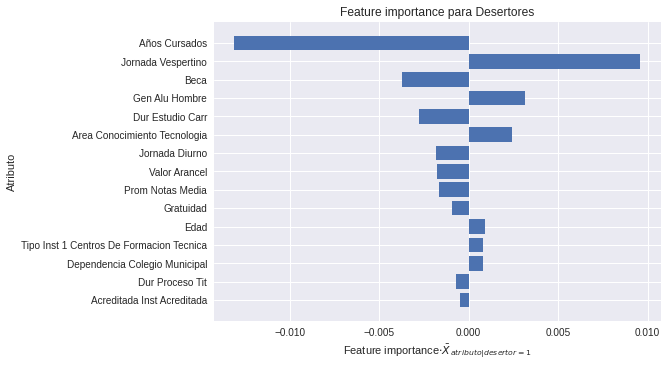

In [20]:
plt.barh(result["atributo"], result[1])
plt.title("Feature importance para Desertores");
plt.xlabel("Feature importance" + r"$\cdot \bar X_{atributo|desertor=1}$");
plt.ylabel("Atributo")

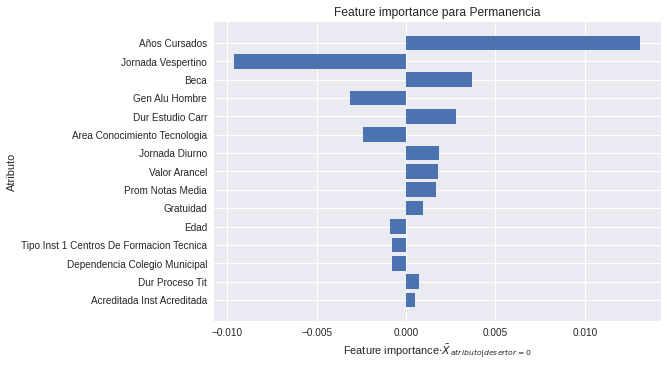

In [21]:
plt.barh(result["atributo"], result[0])
plt.title("Feature importance para Permanencia");
plt.xlabel("Feature importance" + r"$\cdot \bar X_{atributo|desertor=0}$");
plt.ylabel("Atributo");

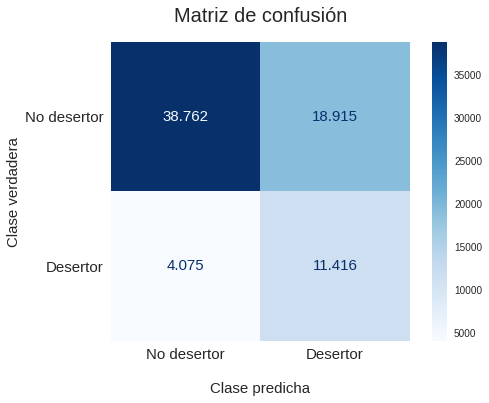

In [22]:
predictions = search.predict(X_test)
clases = search.best_estimator_[1].classes_
cm = confusion_matrix(y_test, predictions, labels=clases)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(cmap="Blues", values_format='');
for labels in disp.text_.ravel():
    t = labels.get_text()
    labels.set_text(locale.format_string('%.0f', int(t), grouping=True, monetary=True))
    labels.set_fontsize(15)
plt.grid(False);
plt.title("Matriz de confusión", fontsize=20, pad=20);
plt.ylabel("Clase verdadera", fontsize=15);
plt.xlabel("Clase predicha", fontsize=15, labelpad=20);
plt.yticks([0, 1], ["No desertor", "Desertor"], fontsize=15);
plt.xticks([0, 1], ["No desertor", "Desertor"], fontsize=15);

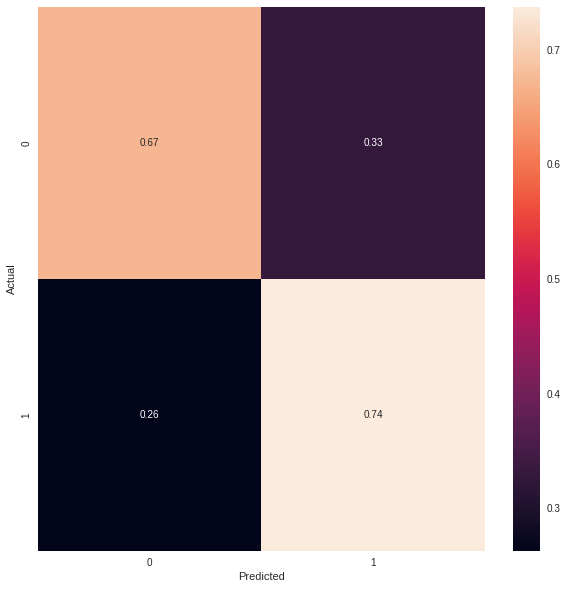

In [28]:
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=clases, yticklabels=clases)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [29]:
con_proba = X_test.copy()
con_proba["desertor_1"] = y_test
con_proba["proba"] = search.predict_proba(X_test)[:, 1]

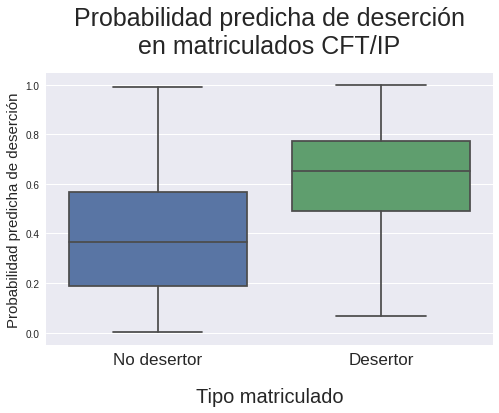

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=con_proba, y="proba", x="desertor_1", showfliers=False);
plt.xticks([0,1], ["No desertor", "Desertor"], fontsize=17);
plt.xlabel("Tipo matriculado", fontsize=20, labelpad=20);
plt.ylabel("Probabilidad predicha de deserción", fontsize=15);
plt.title("Probabilidad predicha de deserción\nen matriculados CFT/IP", fontsize=25, pad=20);

### Shap values

https://github.com/slundberg/shap

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In [31]:
explainer = shap.TreeExplainer(search.best_estimator_['clf'])
observations = search.best_estimator_['selection'].transform(X_train)

In [32]:
shap_e = explainer(observations)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [33]:
shap_values = explainer.shap_values(observations)

In [42]:
renamed = [
    c.replace("_", " ").title()
    for c in columns_with_support
]

renamed[67]

'Sub Tipo Inst Ip Privado Precencia Nacional'

In [43]:
renamed[6] = "Años Cursados"
renamed[67] = 'Sub Tipo Inst Ip Privado Presencia Nacional'

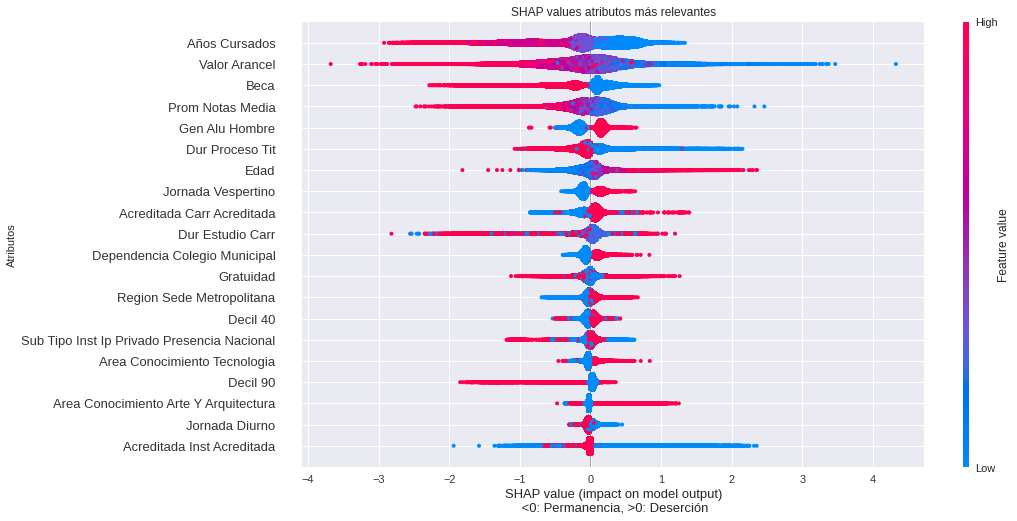

In [44]:
shap.summary_plot(
    shap_values,
    observations,
    class_names=search.best_estimator_['clf'].classes_,
    feature_names=renamed,
    plot_size=[15, 7],
    show=False
)
plt.title("SHAP values atributos más relevantes")
plt.xlabel("SHAP value (impact on model output)\n <0: Permanencia, >0: Deserción")
plt.ylabel("Atributos")
plt.show()

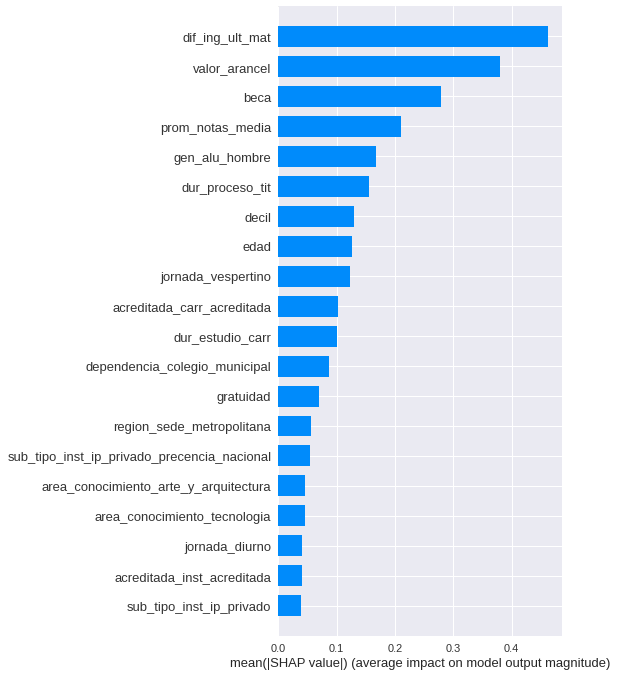

In [37]:
shap.summary_plot(shap_values, observations, plot_type="bar", class_names=search.best_estimator_['clf'].classes_, feature_names=columns_with_support)

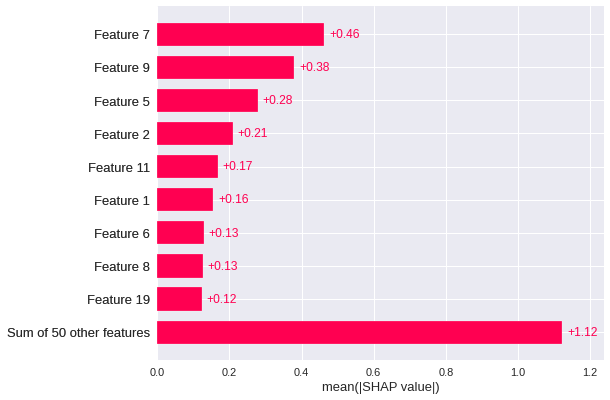

In [38]:
shap.plots.bar(shap_e)

In [39]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.shape[1]):
        importances.append(np.mean(np.abs(shap_values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [40]:
print_feature_importances_shap_values(shap_values, X_test.columns)

dif_ing_ult_mat -> 0.4628 (softmax = 0.0254)
valor_arancel -> 0.3801 (softmax = 0.0234)
beca -> 0.2787 (softmax = 0.0211)
prom_notas_media -> 0.2101 (softmax = 0.0197)
gen_alu_hombre -> 0.1683 (softmax = 0.0189)
dur_proceso_tit -> 0.1551 (softmax = 0.0187)
decil -> 0.1293 (softmax = 0.0182)
edad -> 0.1265 (softmax = 0.0182)
jornada_vespertino -> 0.1232 (softmax = 0.0181)
area_conocimiento_humanidades -> 0.1032 (softmax = 0.0177)
dur_estudio_carr -> 0.1015 (softmax = 0.0177)
tipo_ensenanza_colegio_otro -> 0.0866 (softmax = 0.0174)
gratuidad -> 0.0706 (softmax = 0.0172)
region_sede_maule -> 0.0556 (softmax = 0.0169)
dependencia_colegio_particular_subvencionado -> 0.0552 (softmax = 0.0169)
region_sede_nuble -> 0.0451 (softmax = 0.0167)
area_conocimiento_educacion -> 0.0451 (softmax = 0.0167)
jornada_diurno -> 0.0413 (softmax = 0.0167)
area_conocimiento_tecnologia -> 0.0411 (softmax = 0.0167)
dependencia_colegio_particular_pagado -> 0.0382 (softmax = 0.0166)
tipo_ensenanza_colegio_hc -> 0.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [38]:
shap.initjs()
shap.plots.force(shap_e[:100])

## Dummy

In [44]:
aleatorio = DummyClassifier(strategy="stratified", random_state=42).fit(X_resampled, y_resampled)
print(classification_report(y_test, aleatorio.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.50      0.60     67026
           1       0.24      0.50      0.33     21532

    accuracy                           0.50     88558
   macro avg       0.50      0.50      0.47     88558
weighted avg       0.63      0.50      0.54     88558

